In [3]:
import os

if(os.getcwd().split('\\')[-1] == 'analytic'):           
    os.chdir('../')
os.getcwd()

'S:\\MSE\\project\\rnd-agent'

In [4]:
from typing import List
from tensorflow.python.summary.summary_iterator import summary_iterator
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from utlis.io_helper import OsPath
from tensorflow.python.framework import tensor_util
import os
import yaml
import numpy as np
import tensorflow as tf

import seaborn as sns; sns.set()

from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from matplotlib.image import imread

from analytic.tensorboard_helpers import *
from analytic.analytic_helpers import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

## Constants

In [5]:
run = '2020-08-15-19-48'
log_name = run + '--icm-simple'

event_file_0 = OsPath(f"models/{run}/env_eval_instance_0/")
event_file_1 = OsPath(f"models/{run}/env_eval_instance_1/")
event_file_2 = OsPath(f"models/{run}/env_eval_instance_2/")
event_file_3 = OsPath(f"models/{run}/env_eval_instance_3/")

log_folder = OsPath(f"data/{log_name}/")

log_path_0 = log_folder + "eval_0.yaml"
log_path_1 = log_folder + "eval_1.yaml"
log_path_2 = log_folder + "eval_2.yaml"
log_path_3 = log_folder + "eval_3.yaml"

event_files = [event_file_0, event_file_1, event_file_2,event_file_3]
log_paths = [log_path_0, log_path_1, log_path_2, log_path_3]

event_train_file_0 = OsPath(f"models/{run}/env_instance_0/")
event_train_file_1 = OsPath(f"models/{run}/env_instance_1/")
event_train_file_2 = OsPath(f"models/{run}/env_instance_2/")
event_train_file_3 = OsPath(f"models/{run}/env_instance_3/")
event_train_files = [event_train_file_0, event_train_file_1, event_train_file_2, event_train_file_3]


log_path_train_0 = log_folder + "train_0.yaml"
log_path_train_1 = log_folder + "train_1.yaml"
log_path_train_2 = log_folder + "train_2.yaml"
log_path_train_3 = log_folder + "train_3.yaml"

log_paths_train = [log_path_train_0, log_path_train_1, log_path_train_2, log_path_train_3]

data_folder = OsPath("data/test_simple/")

img_left_bottom = np.array([-7.5, -9.9])
img_right_top = np.array([37.2, 8.1])
level_img_path_0 = 'data/TestLevel0.png'
level_img_path_1 = 'data/TestLevel1.png'
level_img_path_2 = 'data/TestLevel2.png'
level_img_path_3 = 'data/TestLevel3.png'
level_img_left = -7.5
level_img_right = 37.2
level_img_bottom = -9.9
level_img_top = 8.1
img0 = imread(level_img_path_0)
img1 = imread(level_img_path_1)
img2 = imread(level_img_path_2)
img3 = imread(level_img_path_3)
imgs = [img0, img1, img2, img3]

skip_steps = 1000

## Save to file

In [6]:
for log_path, event_file in zip(log_paths, event_files):
    # if not log_path.exists():
        save(log_path, event_file)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [7]:
for log_path, event_file in zip(log_paths_train, event_train_files):
    #if not log_path.exists():
    save_train(log_path, event_file)

## load Data

In [8]:
dicts = [load(log_path) for log_path in log_paths]
dfs = [pd.DataFrame(data=d).iloc[skip_steps:] for d in dicts]

df = pd.DataFrame()
for d in dfs:
    df = pd.concat([df, d])

In [9]:
dicts_train = [load(log_path) for log_path in log_paths_train]
for i in range(len(dicts_train)):
    dicts_train[i].pop('step', None)
    # dicts_train[i]['step'] = dicts_train[i]['step'][::10]
    
dfs_train = [pd.DataFrame(data=d) for d in dicts_train]
df_train = pd.DataFrame()
for d in dfs_train:
    df_train = pd.concat([df_train, d])

# Filter out bad runs

In [10]:
filter = np.zeros(len(dfs_train[0]), dtype=np.int)

for i in range(len(dfs_train[0])//1000):
    max_x = -999999
    for d in dfs_train:
        max_x = max(d.iloc[i*1000:i*1000+1000].x.max(), max_x)
    print(max_x)
    if max_x > 20:
        filter[i*1000:i*1000+1000] = 1

filter = np.array(filter, dtype=bool)
for i in range(len(dfs_train)):
    dfs_train[i] = dfs_train[i][filter]

df = pd.DataFrame()
for d in dfs_train:
    df = pd.concat([df, d])

32.748802185058594


In [11]:
filter = np.zeros(len(dfs[0]), dtype=np.int)

for i in range(len(dfs[0])//1000):
    max_x = -999999
    for d in dfs:
        max_x = max(d.iloc[i*1000:i*1000+1000].x.max(), max_x)
    if max_x > 20:
        filter[i*1000:i*1000+1000] = 1

filter = np.array(filter, dtype=bool)
for i in range(len(dfs)):
    dfs[i] = dfs[i][filter]

df = pd.DataFrame()
for d in dfs:
    df = pd.concat([df, d])

# Train

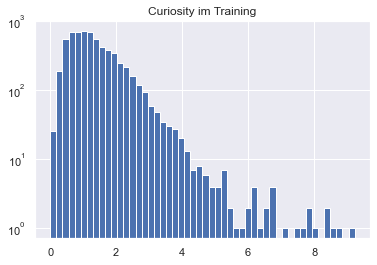

In [12]:
df_train.hist('curiosity', bins=50)
plt.title("Curiosity im Training")
plt.yscale('log')
plt.savefig(str(log_folder + 'hist_train.png'), bbox_inches='tight')
plt.show()

In [13]:
df_train.boxplot('curiosity')

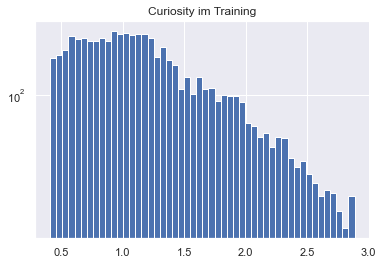

In [14]:
df_train = df_train

removed_outliers = df_train['curiosity'].between(df_train['curiosity'].quantile(.05), df_train['curiosity'].quantile(.95))

df_train = df_train[removed_outliers]

df_train.hist('curiosity', bins=50)
plt.title("Curiosity im Training")
plt.yscale('log')
plt.savefig(str(log_folder + 'hist_train_wo_outlier.png'), bbox_inches='tight')
plt.show()

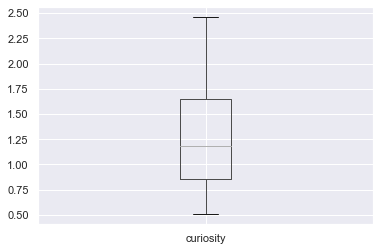

In [60]:
df_train.boxplot('curiosity')

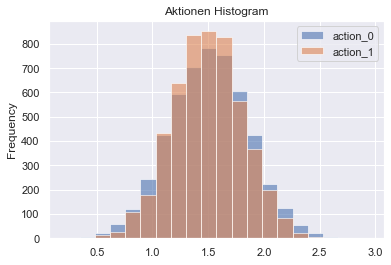

In [61]:
df_train[['action_0', 'action_1']].plot.hist(bins=20, alpha=0.6)
plt.title('Aktionen Histogram')
plt.savefig(str(log_folder + f"action_hists.png"), bbox_inches='tight')
plt.show()

mean 1.3010277192133997
mean 1.1871256232261658
std 0.6009467857212718
max 2.8848917484283447


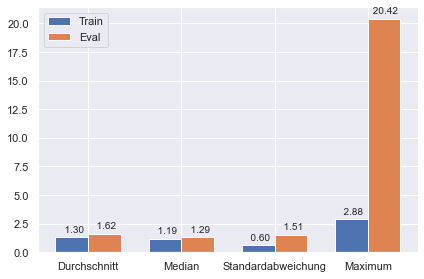

In [16]:
print('mean', df_train['curiosity'].mean())
print('mean', df_train['curiosity'].median())
print('std', df_train['curiosity'].std())
print('max', df_train['curiosity'].max())

labels = ['Durchschnitt', 'Median', 'Standardabweichung', 'Maximum']
train_stats = [
    df_train['curiosity'].mean(), 
    df_train['curiosity'].median(), 
    df_train['curiosity'].std(), 
    df_train['curiosity'].max()]
eval_stats = [
    df['curiosity'].mean(), 
    df['curiosity'].median(), 
    df['curiosity'].std(), 
    df['curiosity'].max()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_stats, width, label='Train')
rects2 = ax.bar(x + width/2, eval_stats, width, label='Eval')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:10.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(-6, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig(str(log_folder + f"stats.png"), bbox_inches='tight')
plt.show()

# Threshold

In [102]:
max_train = df_train['curiosity'].max()
max_eval = df['curiosity'].max()
std_eval = df['curiosity'].std()

max_train + (max_eval - max_train) * 0.5

threshold = max_train + std_eval * 8
print(threshold)

14.53640800080323


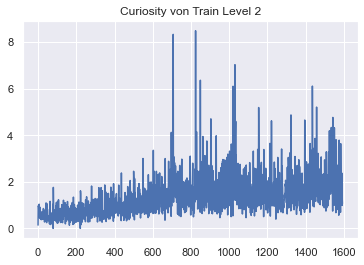

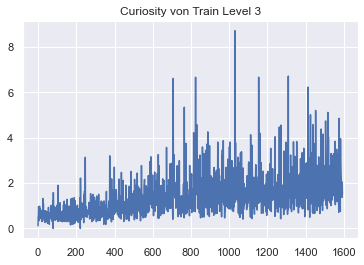

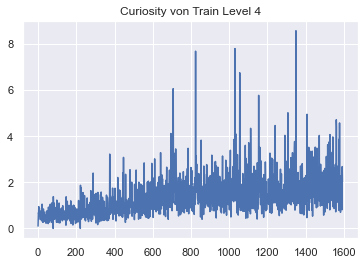

In [15]:
for i, df_t in enumerate(dfs_train):
    df_t.plot(y='curiosity', use_index=True, legend=False)
    plt.title(f"Curiosity von Train Level {i+1}")
    plt.savefig(str(log_folder + f"curiosity_train_{i}.png"), bbox_inches='tight')
    plt.show()

In [ ]:
for i, df_t in enumerate(dfs_train):
    df_t[df_t['extrinsic_reward'] > -10].plot(y='extrinsic_reward', use_index=True, legend=False)
    plt.title(f"Extrinsic Reward von Train Level {i+1}")
    plt.savefig(str(log_folder + f"extrinsic_reward_{i}.png"), bbox_inches='tight')
    plt.show()

In [ ]:
for i, df_t in enumerate(dfs_train):
    df_t.plot(y='total_reward', use_index=True, legend=False)
    plt.title(f"Total Reward von Train Level {i+1}")
    plt.savefig(str(log_folder + f"total_reward_{i}.png"), bbox_inches='tight')
    plt.show()

# Test Level

## Filter out bad runs

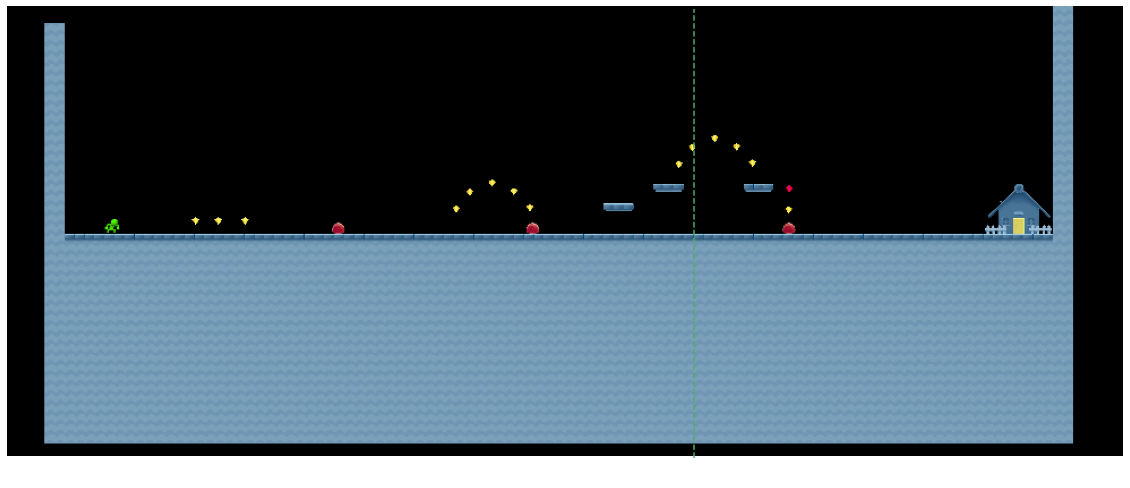

In [16]:
plt.figure(figsize=(20,10))
# plt.scatter([20.0], [0.0])
# plt.title("Minimum erreichte x Koorinaten")
plt.vlines(x=[20.0], ymin=-10, ymax=8, colors='g', linestyles='dashed', label='minimum x wert')
plot_level(img0)
plt.grid(b=None)
plt.axis('off')
plt.savefig(str(log_folder + 'min_x_pos.png'), dpi=300, bbox_inches='tight')
plt.show()

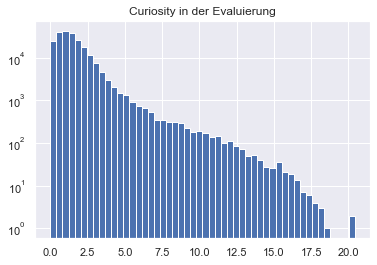

mean 1.6177352302700951
median 1.2935001850128174
std 1.5091054208100136
max 20.416065216064453


In [15]:
df.hist('curiosity', bins=50)
plt.title("Curiosity in der Evaluierung")
plt.yscale('log')
plt.savefig(str(log_folder + 'hist.png'), bbox_inches='tight')
plt.show()
print('mean', df.curiosity.mean())
print('median', df.curiosity.median())
print('std', df.curiosity.std())
print('max', df.curiosity.max())

In [88]:
df[df.curiosity < threshold].hist('curiosity', bins=20)
plt.title("Histogram of the curiosity")
plt.savefig(str(log_folder + 'hist.png'), bbox_inches='tight')
plt.show()

In [89]:
fig, axs = plt.subplots(nrows=2, ncols=2)

axs_flatten = axs.flatten()
for i, df_instance in enumerate(dfs):
    df_instance.plot(y='curiosity', use_index=True, legend=False, ax=axs_flatten[i])
    plt.xlabel('steps')
    plt.ylabel('curiosity')
    plt.title(f"Curiositi von Test Level {i}")
plt.savefig(str(log_folder + f"curiosity_over_steps.png"), bbox_inches='tight')
plt.show()

## Position Plot

<Figure size 1440x720 with 0 Axes>

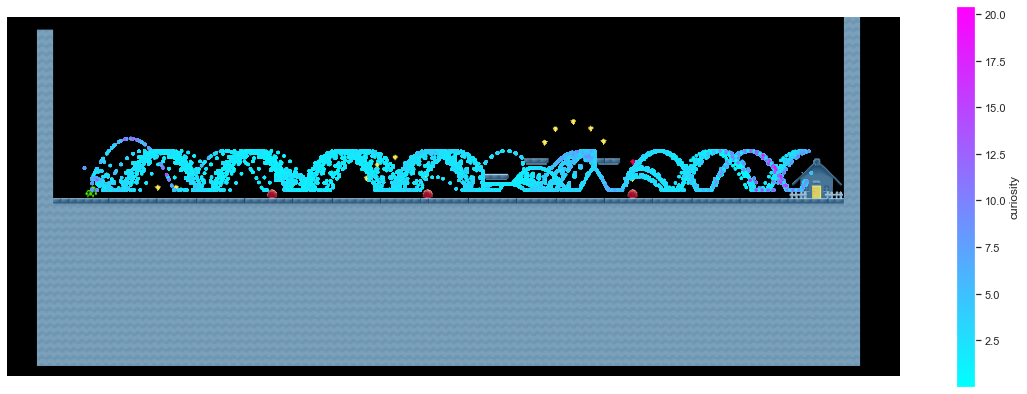

In [90]:
plt.figure(figsize=(20,10))
df.plot.scatter('x', 'y', c='curiosity', s=5, colormap='cool', figsize=(20,7))
plot_level(img0)
plt.grid(b=None)
plt.axis('off')
plt.savefig(str(log_folder + 'position_plot.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def slider_action(start):
    plot_position_slice(start, start+4000, img3, df)

interact(slider_action, start=widgets.IntSlider(min=0, max=len(df), step=4000, value=0))

## Only hight curiosity

count: 151


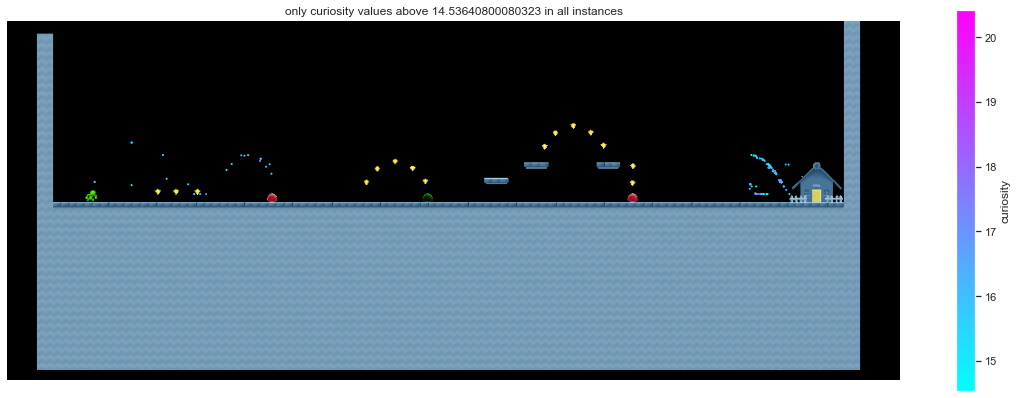

       curiosity    ix   iy          x         y
55116  20.416065  75.0  1.0  30.121468 -0.575000
56115  20.063322  75.0  1.0  30.116585 -0.575000
54117  18.745144  75.0  1.0  30.377846 -0.575000
55493  18.337381  77.0  4.0  30.842924  0.647779
55864  18.150251  77.0  3.0  30.902641  0.569729
55994  18.150251  77.0  3.0  30.902924  0.569731
57747  17.955479  77.0  3.0  30.932730  0.569731
55865  17.623411  78.0  2.0  31.202629  0.120630
55995  17.623411  78.0  2.0  31.202921  0.120630
57624  17.603235  76.0  4.0  30.752907  0.756697


In [91]:
def create_hight_curiosity_plot(data_frame: pd.DataFrame, name: str, ax: plt.Axes = None, figsize=(20,7), size=1) -> plt.Axes:
    return data_frame.plot.scatter('x', 'y', c='curiosity', colormap='cool', s=size, figsize=figsize, 
                                   title=f"only curiosity values above {threshold} in {name}", ax=ax)

df_hight_curiosity = df[df.curiosity > threshold]
print('count:', len(df_hight_curiosity))
create_hight_curiosity_plot(df_hight_curiosity, 'all instances')
plot_level(img1)
disable_grid_and_axis()
plt.savefig(str(log_folder + 'best_curiosity_plot.png'), dpi=300, bbox_inches='tight')
plt.show()
df_sorted = df_hight_curiosity.sort_values(by=['curiosity'], ascending=False)
print(df_sorted.iloc[:10])

## For each Instance

12


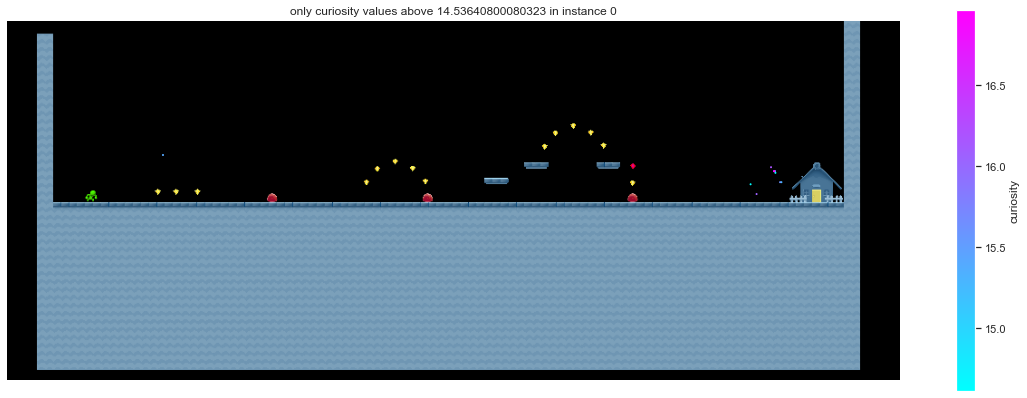

1


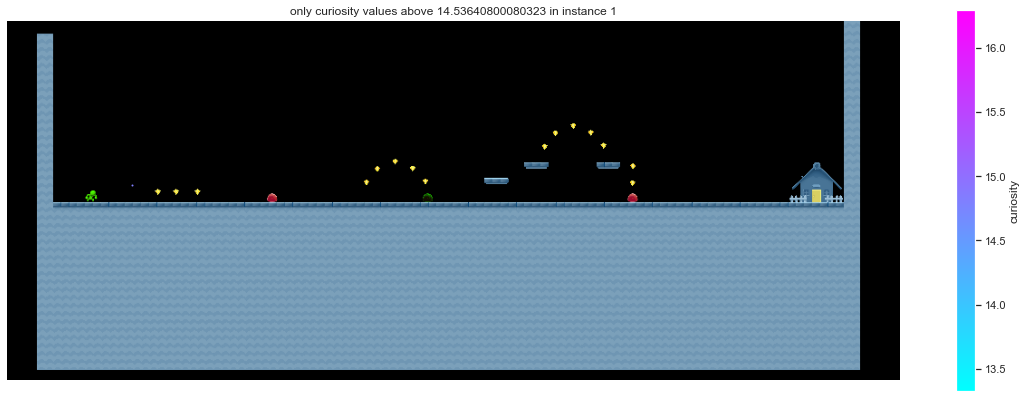

91


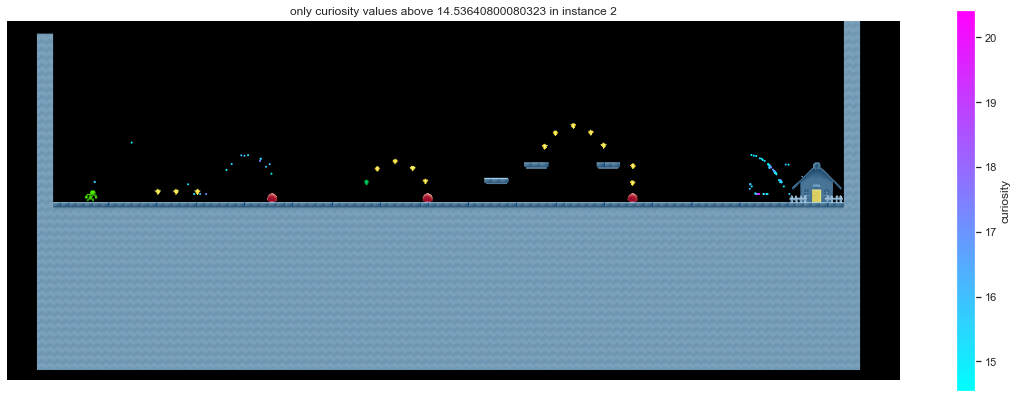

47


In [92]:
for i, df_instance in enumerate(dfs):
    df_hight_curiosity = df_instance[df_instance.curiosity > threshold]
    print(len(df_hight_curiosity))

    create_hight_curiosity_plot(df_hight_curiosity, f"instance {i}")
    plot_level(imgs[i])
    disable_grid_and_axis()
    plt.show()
    df_sorted = df_hight_curiosity.sort_values(by=['curiosity'], ascending=False)

In [1]:
df_bugs = pd.read_json(str(data_folder + 'bug_locations.json'))

df_bugs_0 = df_bugs[df_bugs.InstanceId == 0]
df_bugs_1 = df_bugs[df_bugs.InstanceId == 1]
df_bugs_2 = df_bugs[df_bugs.InstanceId == 2]
df_bugs_3 = df_bugs[df_bugs.InstanceId == 3]

df_bugs_i = [df_bugs_0, df_bugs_1, df_bugs_2, df_bugs_3]

df_bugs

NameError: name 'pd' is not defined

In [95]:
def annotate_bugs_plot(ax, names, xs, ys, char_size=0.3):
    x_text = xs[0] - 5
    for txt, x, y in zip(names, xs, ys):
    # for i, txt in enumerate(names):
        ax.annotate(txt, (x, y), xytext=[x_text, 7], color='white', arrowprops={'arrowstyle': '-', 'color': 'blue', 'lw': 2})
        x_text += len(txt)*char_size

def create_bugs_in_level_plot(data_frame: pd.DataFrame, name:str, ax: plt.Axes = None, char_size=0.3, figsize=(20,7)) -> plt.Axes:
    ax = data_frame.plot.scatter('X', 'Y', s=data_frame.Radius*800, figsize=figsize, title=f"Bugs in {name}", color='none', edgecolors='r', ax=ax)
    df_bugs_plot = data_frame.sort_values('X').reset_index()
    annotate_bugs_plot(ax, df_bugs_plot.Name, df_bugs_plot.X, df_bugs_plot.Y, char_size)
    # x_text = df_bugs_plot.X[0] - 5
    # for i, txt in enumerate(df_bugs_plot.Name):
    #     ax.annotate(txt, (df_bugs_plot.X[i], df_bugs_plot.Y[i]), xytext=[x_text, 7], color='white', arrowprops={'arrowstyle': '-', 'color': 'blue', 'lw': 2})
    #     x_text += len(txt)*0.3

    return ax

create_bugs_in_level_plot(df_bugs, 'all test instance')
plot_level(img0)
disable_grid_and_axis()
plt.savefig(str(log_folder + 'bugs_in_the_level.png'), dpi=300, bbox_inches='tight')
plt.show()

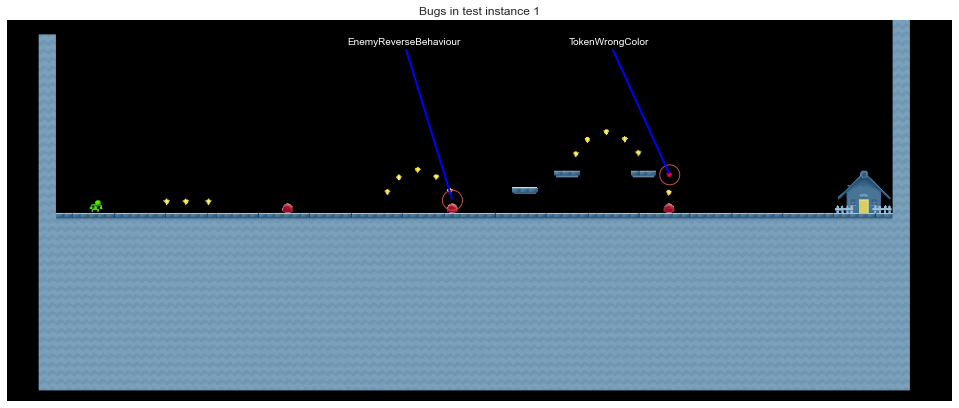

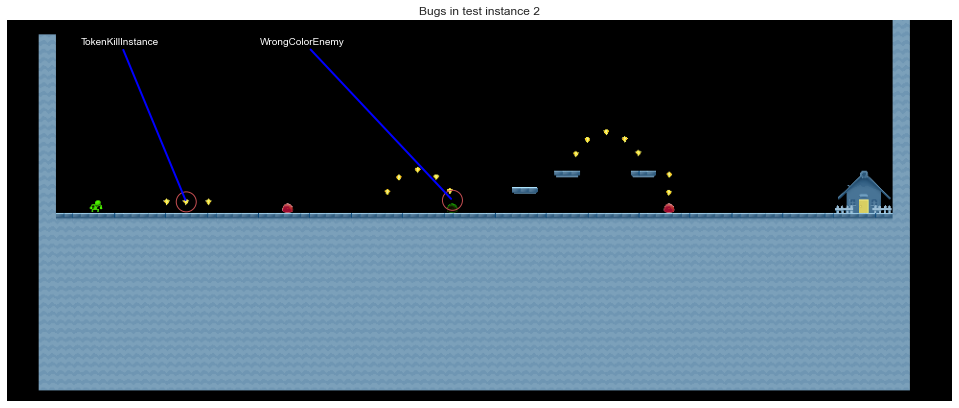

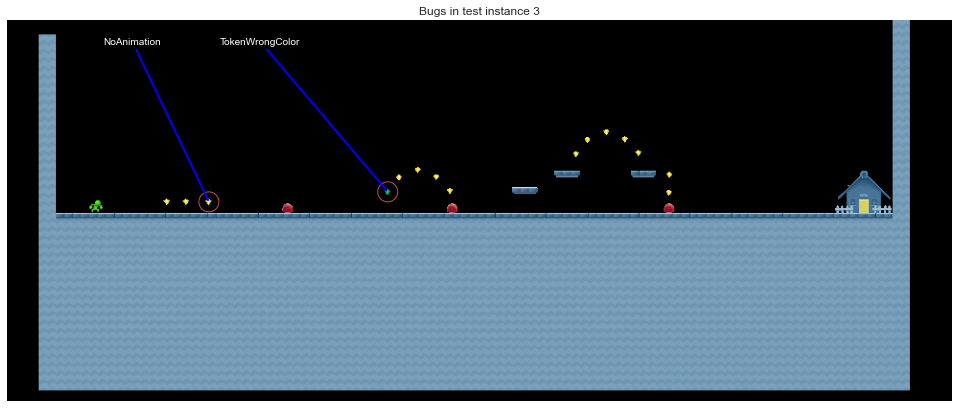

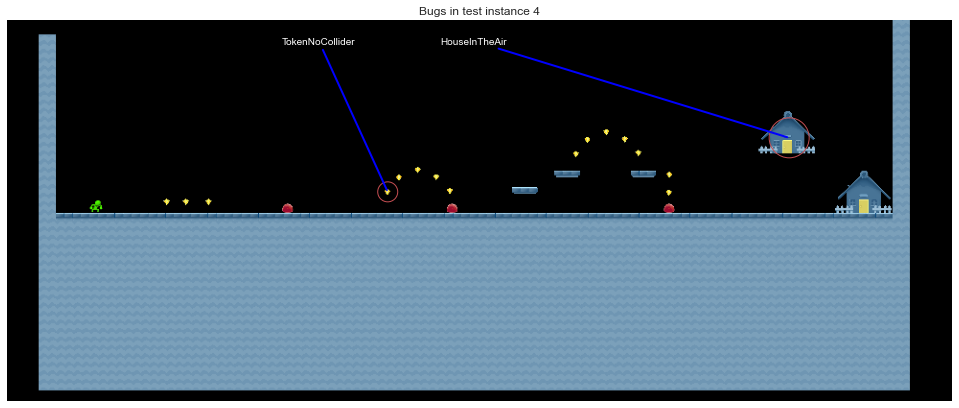

In [96]:
for i, df_bugs_instance in enumerate(df_bugs_i):
    create_bugs_in_level_plot(df_bugs_instance, f"test instance {i+1}", char_size=0.5)
    plot_level(imgs[i])
    disable_grid_and_axis()
    plt.savefig(str(log_folder + f"bugs_in_the_level_{i}.png"), dpi=300, bbox_inches='tight')
    plt.show()

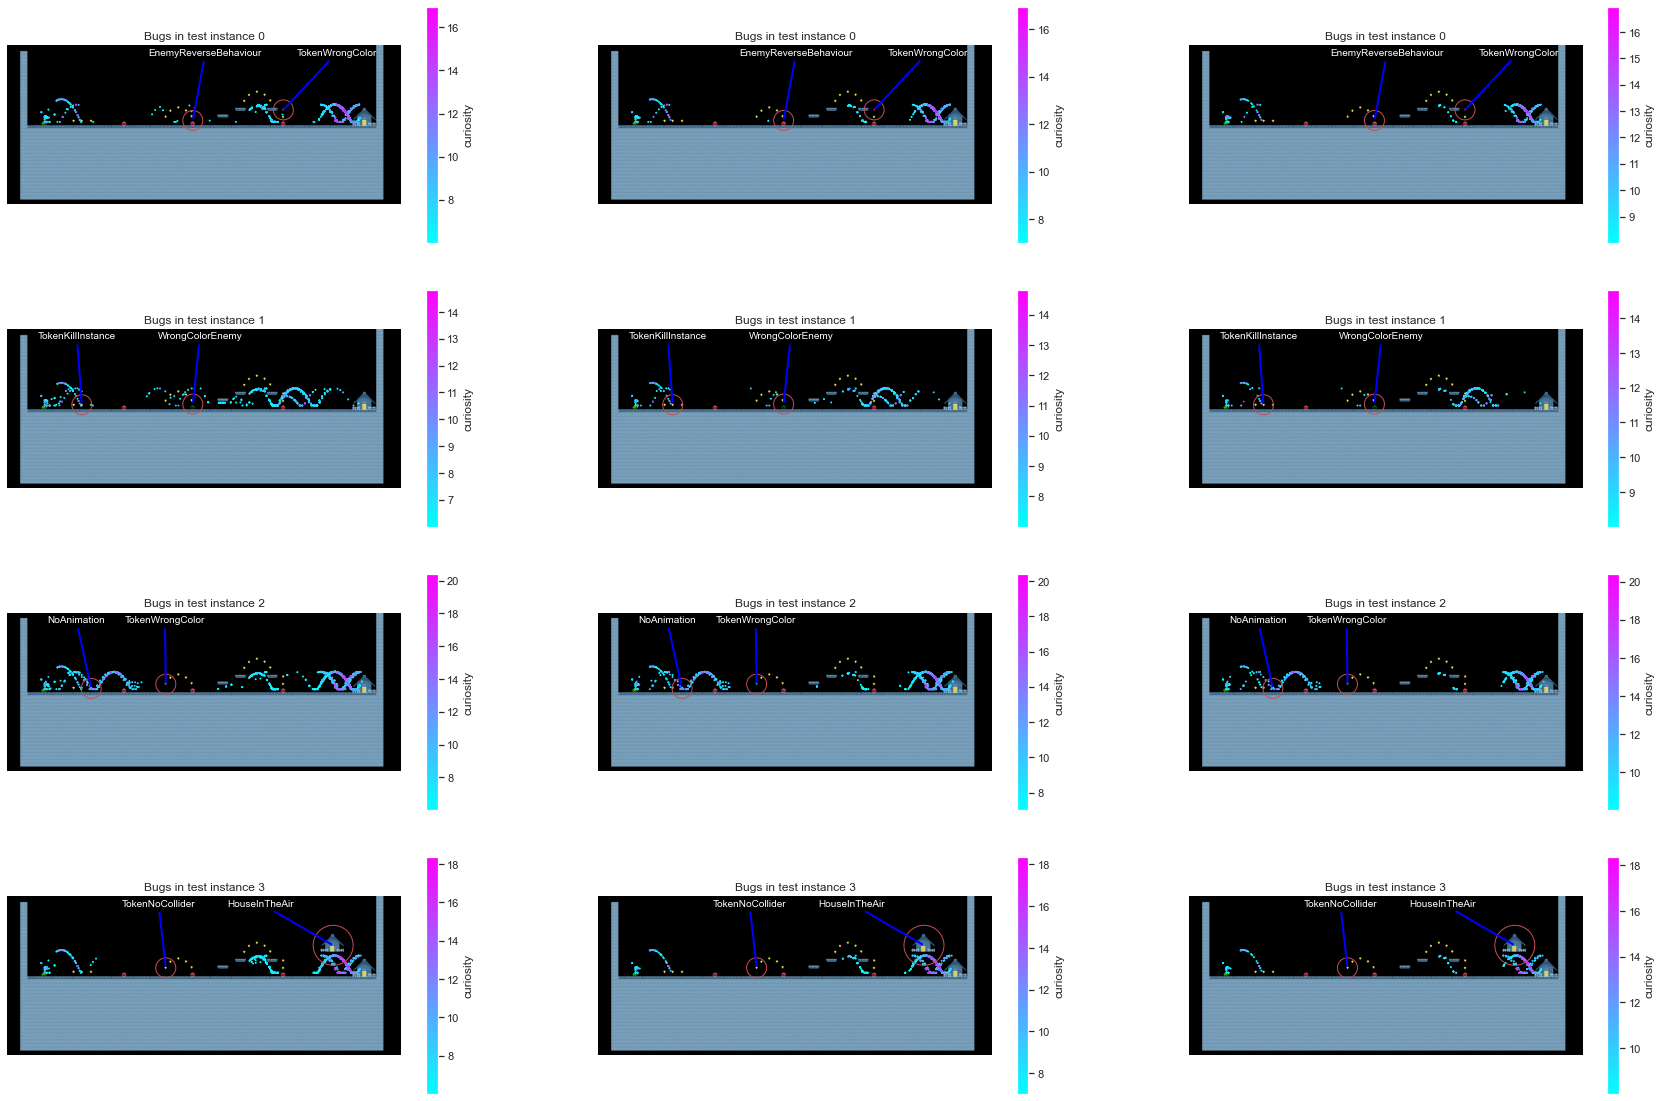

[6, 7, 8]


In [97]:
def plot_bugs_and_hight_curiosity(axs, threshold: float):
    for i, (df_instance, df_bugs_instance) in enumerate(zip(dfs, df_bugs_i)):
        df_hight_curiosity = df_instance[df_instance.curiosity > threshold]
        create_hight_curiosity_plot(df_hight_curiosity, f"instance {i}", axs[i], figsize=None)
        create_bugs_in_level_plot(df_bugs_instance, f"test instance {i}", axs[i], char_size=0.8, figsize=None)
        plot_level(imgs[i], axs[i])
        disable_grid_and_axis(axs[i])
        df_sorted = df_hight_curiosity.sort_values(by=['curiosity'], ascending=False)

thresholds = [6, 7, 8]

fig, axs = plt.subplots(nrows=4, ncols=len(thresholds), figsize=(30,20), clear=True)
for i, t in enumerate(thresholds):
    plot_bugs_and_hight_curiosity(axs[:, i], t)

plt.savefig(str(log_folder + f"best_curiosity_plot_{thresholds}.png"), dpi=300, bbox_inches='tight')
plt.show()

print(thresholds)

## Bugs found

In [98]:
def eval_bugs(threshold: float):
    true_positives = [[], [], [], []]
    false_positives = [[], [], [], []]
    bug_names = set()

    tp = 0
    fp = 0
    tn = 0
    fn = 0

    camera_radius = 4

    for instance_id, df_instance in enumerate(dfs):
        df_instance_positiv = df_instance[df_instance.curiosity > threshold]
        df_instance_negative = df_instance[df_instance.curiosity <= threshold]
        for i, r_test in df_instance_positiv.iterrows():
            test_pos = np.array([r_test.x, r_test.y])
            is_real_bug = False
            for j, r_bugs in df_bugs_i[instance_id].iterrows():
                bug_pos = np.array([r_bugs.X, r_bugs.Y])
                dist = np.linalg.norm(bug_pos - test_pos)

                c_radius = camera_radius if r_bugs['Visible'] else 0
                if dist < r_bugs.Radius + c_radius:
                    if r_bugs.Name not in bug_names:
                        bug_names.add(r_bugs.Name)

                    bugs_dict = {'x': r_test.x, 'y': r_test.y, 'name': r_bugs.Name, 'curiosity': r_test.curiosity, 'instance_id': instance_id}
                    true_positives[instance_id].append(bugs_dict)
                    tp += 1
                    is_real_bug = True
            if not is_real_bug:
                fp += 1
                false_positives[instance_id].append(test_pos)

        for i, r_test in df_instance_negative.iterrows():
            test_pos = np.array([r_test.x, r_test.y])
            is_real_bug = False
            for j, r_bugs in df_bugs_i[instance_id].iterrows():
                bug_pos = np.array([r_bugs.X, r_bugs.Y])
                dist = np.linalg.norm(bug_pos - test_pos)

                c_radius = camera_radius if r_bugs['Visible'] else 0
                if dist < r_bugs.Radius + c_radius:
                    fn += 1
                    is_real_bug = True
            if not is_real_bug:
                tn += 1
                
    return true_positives, false_positives, tp, fp, tn, fn, bug_names

In [107]:
accuracys = []
precisions = []
recalls = []
f1s = []
thresholds = np.arange(threshold - std_eval * 2, threshold + std_eval * 3, std_eval)
tps = []
fps = []
tns = []
fns = []
all_bugs_found = []

for t in thresholds:
    true_positives, false_positives, tp, fp, tn, fn, bugs_found = eval_bugs(t)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = (2 * tp)/ (2 * tp + fp + fn)
    p_bugs_found = len(bugs_found) / len(df_bugs)
    
    if p_bugs_found <= 0:
        break
    
    accuracys.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    all_bugs_found.append(p_bugs_found)
    
    print('threshol', t)
    print('true positive', tp)
    print('false positive', fp)
    print('true negative', tn)
    print('false negative', fn)
    print('accuracy', accuracy)
    print('precision', precision)
    print('recall', recall)
    print('f1', f1)
    print('bugs_found', f"{len(bugs_found)} / {len(df_bugs)}")
    print('bugs_found_p', len(bugs_found) / len(df_bugs))
    print()

threshol 11.518197159183202
true positive 168
false positive 484
true negative 159170
false negative 68963
accuracy 0.6964530017265118
precision 0.25766871165644173
recall 0.0024301688099405477
f1 0.004814926271441469
bugs_found 3 / 8
bugs_found_p 0.375

threshol 13.027302579993217
true positive 107
false positive 208
true negative 159446
false negative 69024
accuracy 0.6973927486504797
precision 0.3396825396825397
recall 0.0015477860872835632
f1 0.003081530973706189
bugs_found 2 / 8
bugs_found_p 0.25

threshol 14.536408000803231
true positive 61
false positive 90
true negative 159564
false negative 69070
accuracy 0.6977074545971108
precision 0.40397350993377484
recall 0.0008823827226569845
f1 0.0017609191420571
bugs_found 2 / 8
bugs_found_p 0.25

threshol 16.045513421613244
true positive 26
false positive 26
true negative 159628
false negative 69105
accuracy 0.6978342111589484
precision 0.5
recall 0.0003760975539193705
f1 0.0007516297356286949
bugs_found 2 / 8
bugs_found_p 0.25

thres

In [108]:
# plt.plot(thresholds, accuracys, label='accuracy')
thresholds = thresholds[:len(precisions)]
plt.plot(thresholds, precisions, label='Präzision')
# plt.plot(thresholds, recalls, label='recall')
# plt.plot(thresholds, f1s, label='f1')
plt.plot(thresholds, all_bugs_found, label='Bugs gefunden')
plt.xlabel('Schwelle')
plt.ylabel('Relativer Wert')
plt.legend()
plt.savefig(str(log_folder + f"threshold_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

In [80]:
true_positives, false_positives, tp, fp, tn, fn, bugs_found = eval_bugs(threshold)

instance 0
true_positive 0
false_positive 12



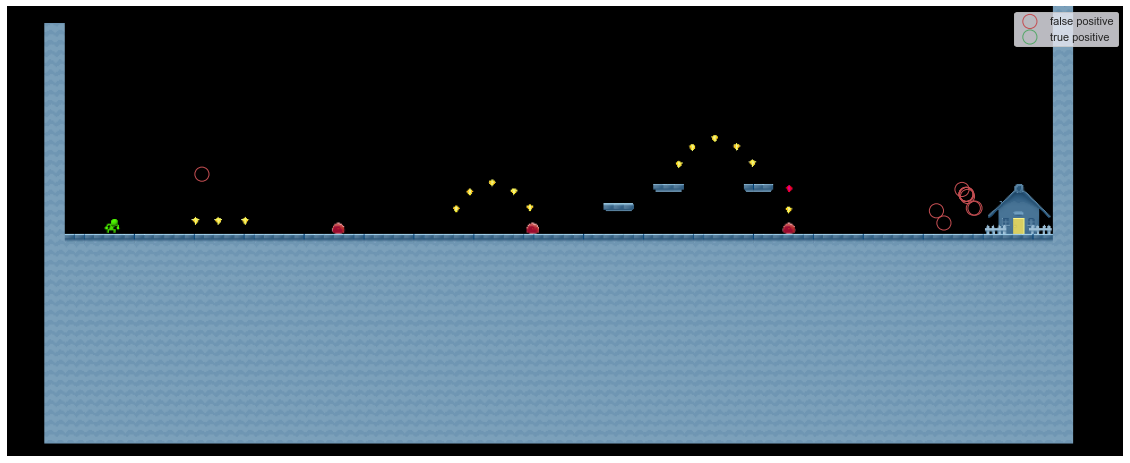

instance 1
true_positive 0
false_positive 1



instance 2
true_positive 16
false_positive 75



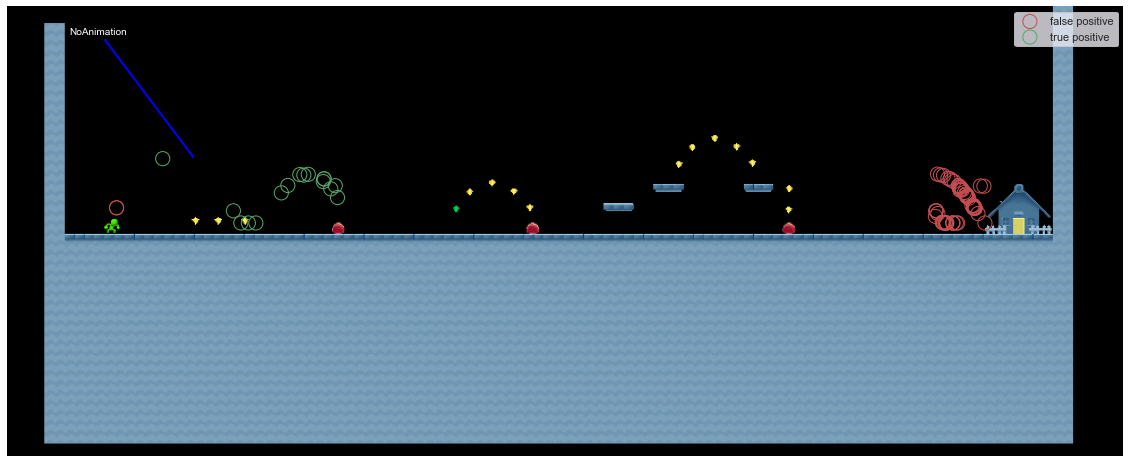

instance 3
true_positive 45
false_positive 2



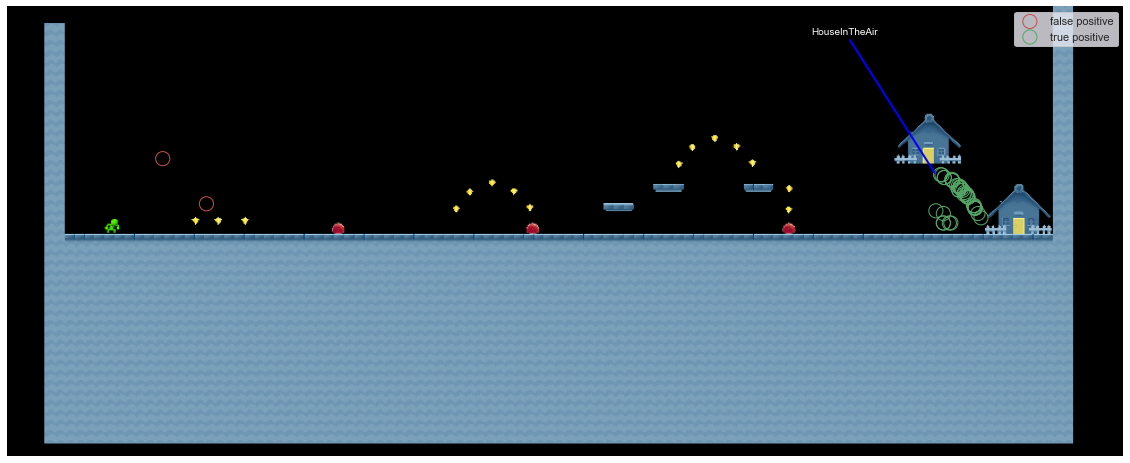

In [81]:
for j, (true_pos, false_pos) in enumerate(zip(true_positives, false_positives)):
    print(f"instance {j}")
    print('true_positive', len(true_pos))
    print('false_positive', len(false_pos))
    print()
    
    fig = plt.figure(figsize=(20, 10))
    x_false = np.array([row[0] for row in false_pos])
    y_false = np.array([row[1] for row in false_pos])
    plt.scatter(x_false, y_false, s=200, color='none', edgecolors='r', label="false positive")
    
    x = np.array([row['x'] for row in true_pos])
    y =  np.array([row['y'] for row in true_pos])
    names = np.array([row['name'] for row in true_pos])

    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    names = names[idx]

    names_set = set()

    plt.scatter(x, y, s=200, color='none', edgecolors='g', label="true positive")
    k = 0

    df_tmp = pd.DataFrame(data={'x': x, 'y': y, 'names': names})
    df_tmp = df_tmp.groupby(['names']).agg({'x': 'min', 'y': 'max'})
    df_tmp = df_tmp.clip(0)
    if(len(df_tmp) > 0):
        annotate_bugs_plot(fig.axes[0], df_tmp.index.tolist(), df_tmp.x.tolist(), df_tmp.y.tolist())

    plot_level(imgs[j])
    disable_grid_and_axis()
    plt.legend()
    # plt.title(f"Bugs found in instance {j} with curiosity > {threshold}")
    plt.savefig(str(log_folder + f"bugs_found_{j}.png"), dpi=300, bbox_inches='tight')
    plt.show()

threshol 14.53640800080323
true positive 61
false positive 90
true negative 159564
false negative 69070
accuracy 0.6977074545971108
precision 0.40397350993377484
recall 0.0008823827226569845
bugs_found {'HouseInTheAir', 'NoAnimation'}



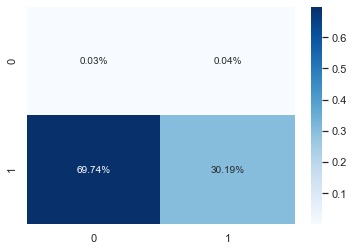

In [82]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print('threshol', threshold)
print('true positive', tp)
print('false positive', fp)
print('true negative', tn)
print('false negative', fn)
print('accuracy', accuracy)
print('precision', precision)
print('recall', recall)
print('bugs_found', bugs_found)
print()

cf_matrix = np.array([
    [tp, fp], 
    [tn, fn]])
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(25,30), clear=True)
plot_bugs_and_hight_curiosity(axs.flatten(), threshold)
plt.savefig(str(log_folder + f"best_curiosity_plot_all.png"), dpi=300, bbox_inches='tight')
plt.show()